# Attention

## 1.背景
- 在深度学习中，注意力是一种**信息筛选技术**，其灵感源于人类视觉/认知系统对关键信息的选择性关注。
- **核心思想**：根据输入的不同部分对当前任务的重要性，动态分配不同的权重。这种权重分配不是固定的，而是根据上下文动态计算的。

## 2. 数学框架：Q,K,V
### 2.1 如何理解?
想象你在图书馆找书：
- Q: 你的需求（如“找一本关于深度学习的书”）—— 目标
- K： 所有书的书名、作者、分类标签—— 可检索的线索
- V：每本书的具体内容——待提取的信息

### 2.2 Q,K,V的数学本质
#### 2.1 输入预处理
假设 输入序列为$mathbf{X} \in\mathbb{R}^{L \times d_{\text{model}}} $,通过三个权重矩阵生成：
，通过三个权重矩阵$ \mathbf{W}^Q, \mathbf{W}^K, \mathbf{W}^V \in \mathbb{R}^{d_{\text{model}} \times d_k}$生成：
$$
\begin{align*}
\mathbf{Q} &= \mathbf{X}\mathbf{W}^Q, \\
\mathbf{K} &= \mathbf{X}\mathbf{W}^K, \\
\mathbf{V} &= \mathbf{X}\mathbf{W}^V.
\end{align*}
$$

#### 2.2 注意力分数

**相似度计算**：反应目标与线索的匹配度
 - $\mathbf{Q}$ 和 $\mathbf{K}$ 计算每个位置的注意力分数

 $$\text{Score}(i, j) = \frac{\mathbf{Q}_i \cdot \mathbf{K}_j}{\sqrt{d_k}}$$

**Softmax归一化**：
$$
\alpha_{ij} = \text{Softmax}(\text{Score}(i, j))
$$

**加权聚合**
按权重整合$V$信息
$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \sum \alpha_{ij} \mathbf{V}_j
$$

![QKV 示意图](https://d2l.ai/_images/qkv.svg)

### 3. 注意力可视化

In [14]:
from typing import Optional, List, Union, Tuple

from matplotlib.pyplot import tight_layout, show, subplots
from numpy import ndarray
from seaborn import heatmap
from torch import Tensor
from torch.ao.quantization.fx.utils import return_arg_list


def plot_attention_heatmap(
        weights: Union[Tensor, ndarray],
        x_label: str = 'keys',
        y_label: str = 'Queries',
        title: Optional[Union[List[str], str]] = "Attention Weight",
        figsize: Tuple[float, float] = (5, 5),
):
    weights_np = weights.detach().cpu().numpy() if isinstance(weights, Tensor) else weights

    if weights_np.ndim < 4:
        raise ValueError(f"Expected weights with at least 4 dimensions, got {weights_np.ndim}")

    # 解包前四维（ax_row: 子图行数，ax_cols: 子图列数，H: 热力图高度，W: 热力图宽度）
    ax_row, ax_cols, H, W = weights_np.shape[:4]
    total_figsize = (figsize[0] * ax_row, figsize[1] * ax_cols)  # 总图幅大小

    # 创建子图（squeeze=False确保axes为二维数组）
    fig, axes = subplots(ax_row, ax_cols, figsize=total_figsize, squeeze=False)

    # 校验标题列表长度（若为列表）
    if isinstance(title, list):
        expected_length = ax_row * ax_cols
        if len(title) != expected_length:
            raise ValueError(f"Title list length ({len(title)}) must match number of subplots ({expected_length})")

    # 遍历所有子图
    for i in range(ax_row):
        for j in range(ax_cols):
            current_title = title if isinstance(title, str) else title[i * ax_cols + j]

            heatmap_data = weights_np[i, j, :, :]

            ax = axes[i, j]

            heatmap(heatmap_data, cmap='YlOrRd', square=True, xticklabels=5, yticklabels=5, ax=ax, cbar=False)

            ax.set_title(current_title)
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
    tight_layout()
    show()

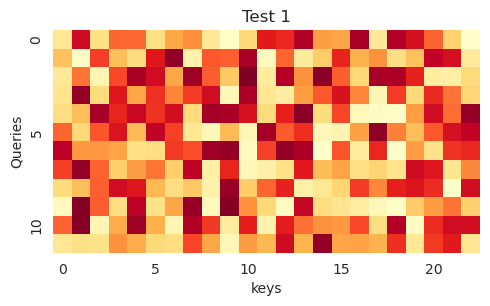

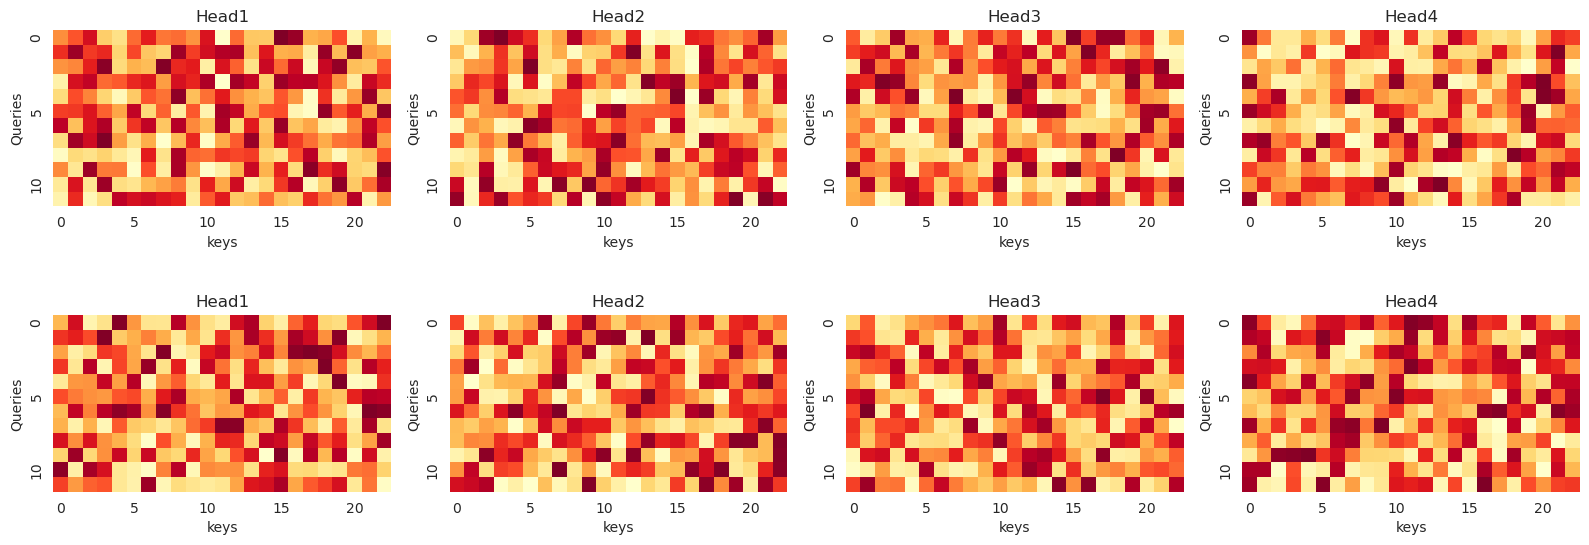

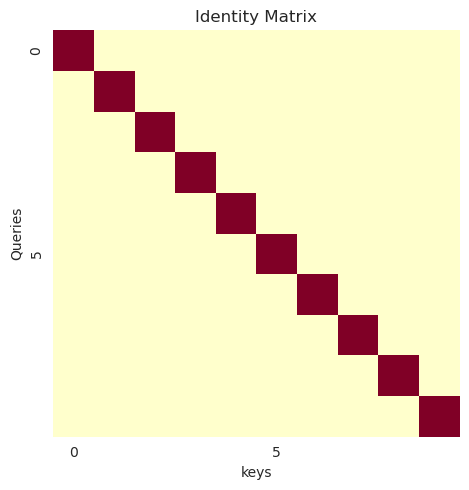

In [40]:
from numpy import random
import torch

weights1 = random.rand(1, 1, 12, 23)
plot_attention_heatmap(weights1, title="Test 1")

weights2 = random.rand(2, 4, 12, 23)
titles2 = [f'Head{i + 1}' for i in range(weights2.shape[1])] * weights2.shape[0]  # 长度8，匹配2 * 4=8
plot_attention_heatmap(weights2, title=titles2, figsize=(8, 1.5))

weights3 = torch.eye(10).reshape(1, 1, 10, 10)
plot_attention_heatmap(weights3, title="Identity Matrix")

## 4.Nadaraya-Watson 核回归
### 4.1 核心思想
一种非参数回归方法，用于估计输入变量（特征）与连续输出变量（目标）之间的未知关系。其核心思想是“**局部加权平均**”：对于每个待预测点，仅利用其邻近的训练数据点，通过核函数赋予这些点不同的权重，最终用加权平均的方式预测该点的输出值。

传统参数回归（如线性回归、多项式回归）假设输入与输出之间存在某种固定形式的函数关系（如线性、二次），并通过最小化误差来拟合参数。但现实中，许多问题的真实关系可能高度复杂（非线性、非平稳），**参数模型难以准确描述**。此时，非参数回归方法（如核回归、局部加权散点图平滑）因不预设函数形式，能灵活捕捉数据的局部特征而被广泛使用。

是一种**静态的、无查询**的局部平滑。

### 4.2 数学形式：如何计算加权平均？

$$
\hat{f}(x) = \frac{ K\left( \frac{x - X_i}{h} \right) Y_i}{\sum_{i=1}^n K\left( \frac{x - X_i}{h} \right)}
$$
其中：
• $K(\cdot)$ 是核函数（Kernel Function），用于衡量数据点 $X_i$ 与目标点 $x$ 的“邻近程度”；

• $h > 0$ 是带宽（Bandwidth），控制核函数的宽度（即邻域的大小）；

• 分子是 $Y_i$ 的加权求和（权重由核函数决定），分母是权重的总和（用于归一化，确保 $\hat{f}(x)$ 是加权平均）。
### 4.3 核函数
- Gaussian Kernel :$K(u)=\frac{1}{\sqrt(2\pi)} e^-\frac{1}{2}u^2$

### 4.4 测试数据集
$$
y = 2 \sin(x) + x + \epsilon
$$

In [41]:
import torch


def f(x):
    return 2 * torch.sin(x) + x


n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)

x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

In [42]:
x_val

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])

In [43]:
def gaussian(x):
    return torch.exp(-torch.pow(x, 2) / 2)

In [44]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    # 广播机制 (N,1)-(1,M) --> (N,M)
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    k = kernel(dists).type(torch.float32)
    '''
    k.sum(0)：对核矩阵 k按列求和（dim=0），得到形状为 (1, M)的向量，其中每个元素是验证点 x[j]对应的所有训练点核值之和；
    k / k.sum(0)：对每个验证点 j，将其对应的所有训练点 i的核值 k[i,j]除以该列的和，使每个验证点的权重和为 1（归一化）；
    attention_w的形状为 (N, M)，其中 attention_w[i,j]表示训练点 x_train[i]对验证点 x_val[j]的贡献权重。
    '''
    attention_W = k / k.sum(0)
    # (N,)@(N,M)-->(M,)
    y_hat = y_train @ attention_W
    return y_hat, attention_W

In [45]:
import matplotlib.pyplot as plt


def plot_reg_compare(x_test, y_val, y_pred, title="Regression Comparison"):
    plt.figure(figsize=(8, 6))
    plt.plot(x_test, y_val, label='y')
    plt.scatter(x_test, y_pred, label='y_pred')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [46]:
y_hat, attention_W = nadaraya_watson(x_train, y_train, x_val, kernel=gaussian)
x_val.shape, y_hat.shape

(torch.Size([50]), torch.Size([50]))

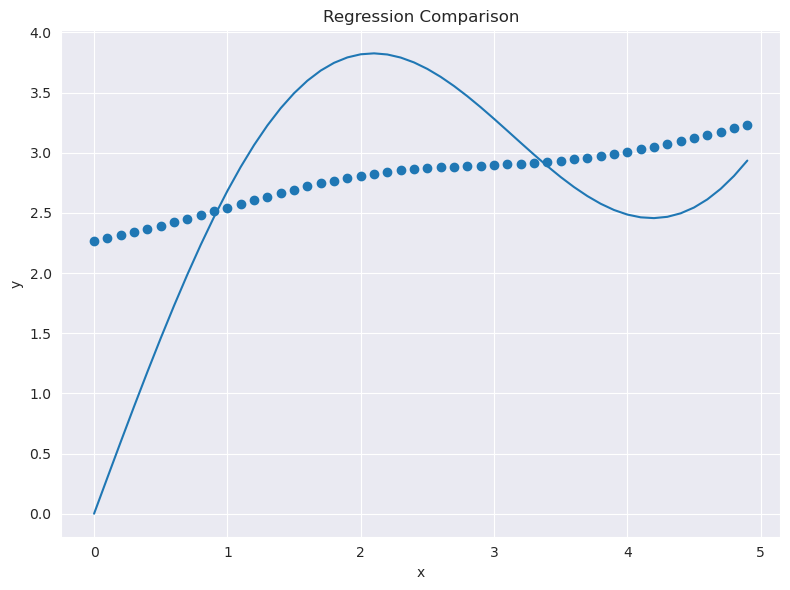

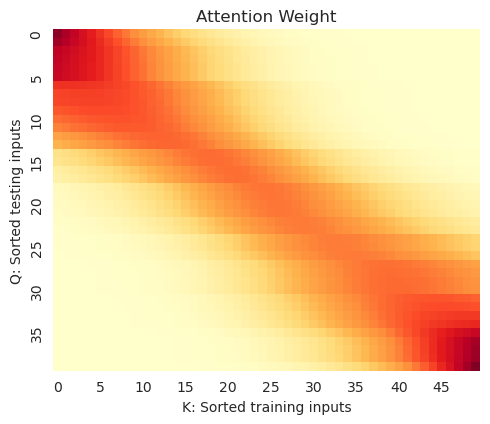

In [47]:
plot_reg_compare(x_val, y_val, y_hat)
# unsqueeze(0) :(N,W)->(1,N,W)
plot_attention_heatmap(attention_W.unsqueeze(0).unsqueeze(0), x_label='K: Sorted training inputs',
                       y_label="Q: Sorted testing inputs", title='Attention Weight')

### 4.4  带宽h和注意力的关系


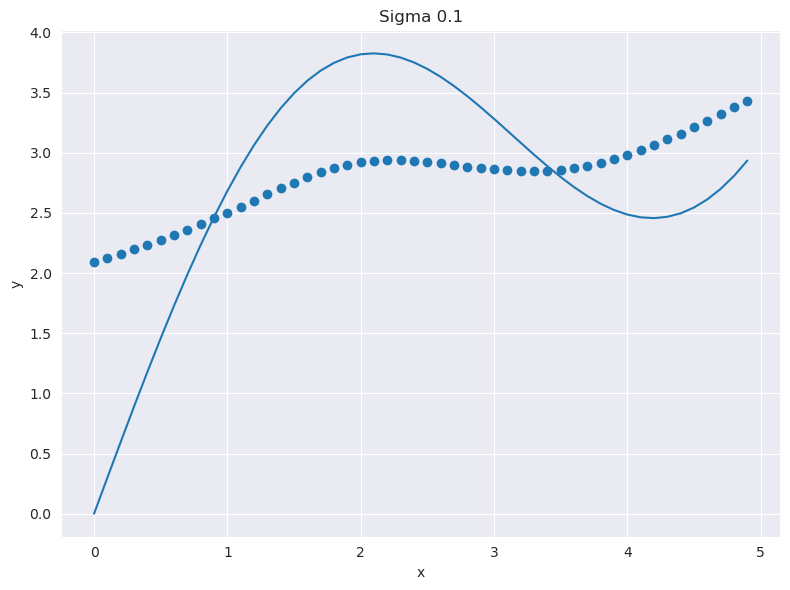

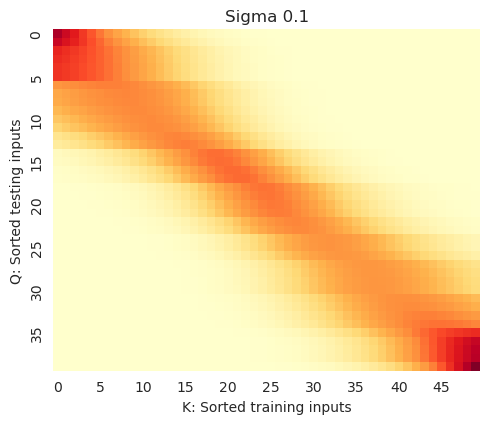

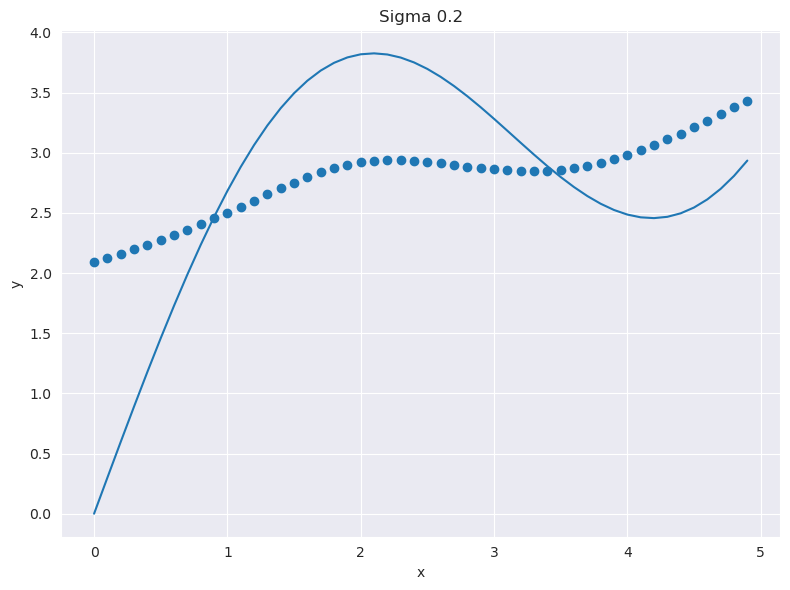

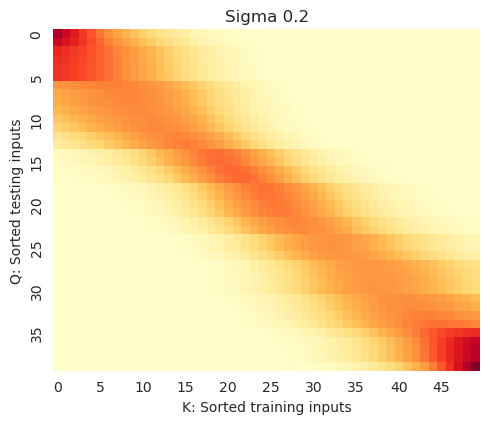

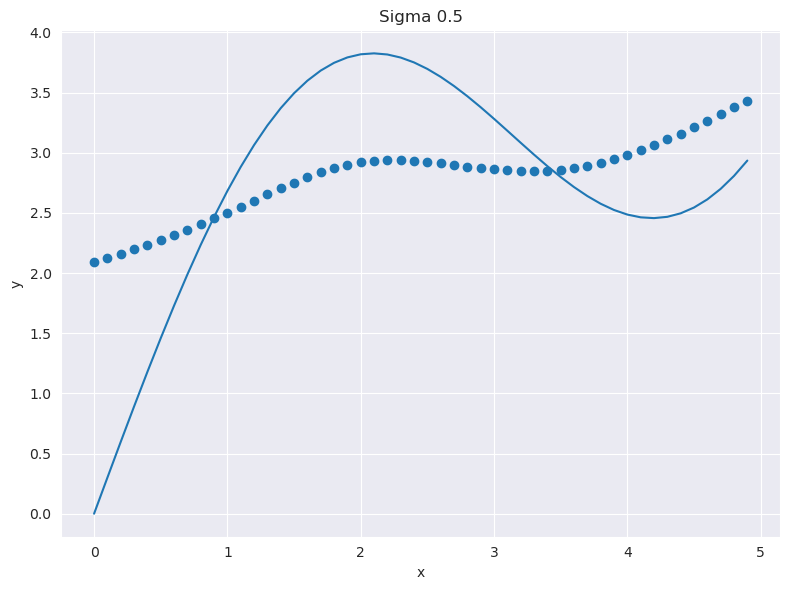

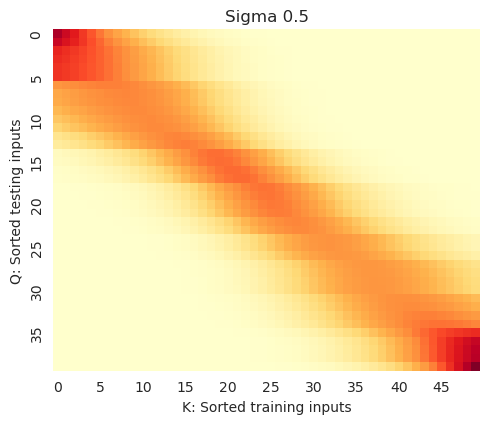

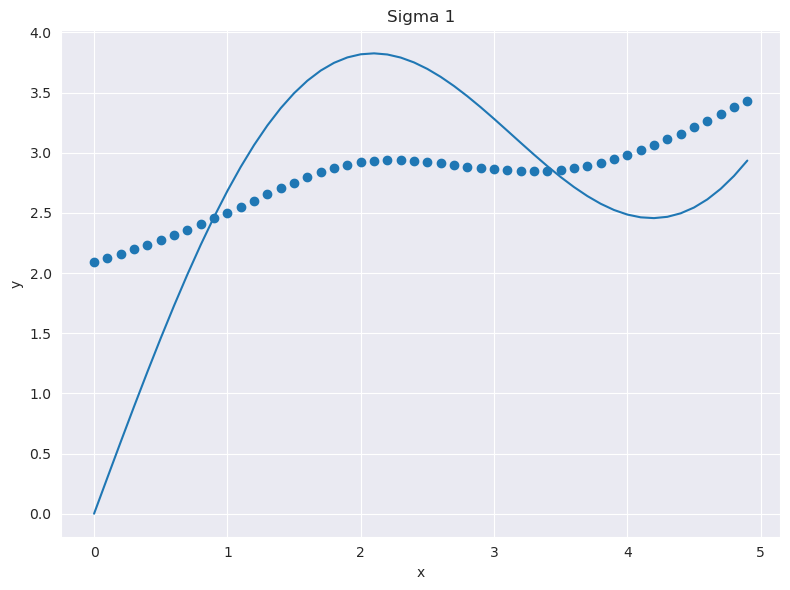

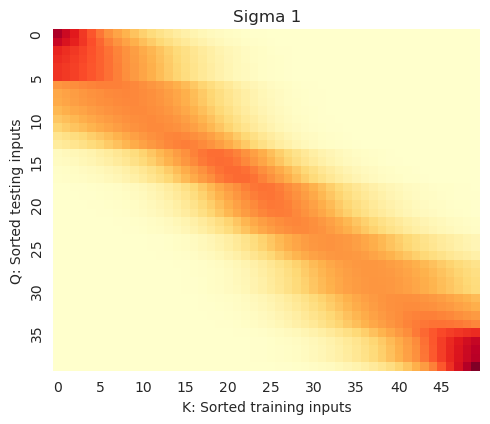

In [48]:
sigma = (0.1, 0.2, 0.5, 1)


def gauassian_h(sigmam):
    # 闭包
    return (lambda x: torch.exp(-x ** 2) / (2 * sigmam ** 2))


kernels = []

for s in sigma:
    names = f'Sigma {s}'
    y_hat, attention_W = nadaraya_watson(x_train, y_train, x_val, kernel=gauassian_h(s))
    plot_reg_compare(x_val, y_val, y_hat, title=names)
    plot_attention_heatmap(attention_W.unsqueeze(0).unsqueeze(0), x_label='K: Sorted training inputs',
                           y_label="Q: Sorted testing inputs", title=names)


## 5. 注意力评分函数

注意力评分函数（Attention Scoring Function）是注意力机制的核心组件，其核心作用是**量化查询（Query）与键（Key）之间的相关性**，输出一个分数（Score），表示两者之间的关联程度。这个分数将用于后续通过 Softmax 计算注意力权重（Attention Weights），最终加权聚合值（Value）得到上下文向量（Context Vector）。

![](https://d2l.ai/_images/attention-output.svg)
### 5.1 数学形式

评分函数的数学形式因注意力机制类型而异，但核心逻辑是将查询和键的特征映射到同一空间，并计算其相似性。以下是最常见的几类评分函数：

#### 1. 点积评分（Dot-Product Scoring）

$$
s(q, k_i) = q^\top k_i
$$

**核心思想**：直接通过向量点积衡量查询与键的线性相关性。点积结果越大，说明两者在特征空间中的方向越接近，相关性越强。

**特点**：
- **计算高效**：仅需矩阵乘法（时间复杂度 $O(d_q d_k)$，$d_q$ 为查询维度，$d_k$ 为键维度）；
- **高维敏感性**：当 $d_q$ 或 $d_k$ 较大时，点积结果可能因数值过大导致 Softmax 梯度消失（需配合缩放因子缓解）。

#### 2. 缩放点积评分（Scaled Dot-Product Scoring）

$$
s(q, k_i) = \frac{q^\top k_i}{\sqrt{d_k}}
$$

**核心思想**：在点积基础上引入缩放因子 $\frac{1}{\sqrt{d_k}}$，缓解高维空间中点积结果过大的问题。

**特点**：
- **解决梯度消失**：缩放因子将点积结果的方差稳定在合理范围（尤其当 $d_k$ 较大时）；
- **Transformer 默认**：这是原始 Transformer 模型中使用的标准评分函数。

#### 3. 加性评分（Additive Scoring，Bahdanau 注意力）

$$
s(q, k_i) = v^\top \tanh\left( W_1 q + W_2 k_i + b \right)
$$

**核心思想**：通过线性组合查询和键的特征，引入非线性激活函数（如 $\tanh$），增强对复杂模式的建模能力。

**特点**：
- **非线性增强**：$\tanh$ 激活函数将线性组合后的特征映射到 $(-1,1)$，捕捉查询与键的非线性关联；
- **参数较多**：需学习 $W_1, W_2, b, v$ 等参数（增加了模型复杂度）；
- **早期经典**：Bahdanau 等人在 2015 年提出的加性注意力，是神经机器翻译（NMT）的里程碑设计。

#### 4. 乘性评分（Multiplicative Scoring，Luong 注意力）

$$
s(q, k_i) = q^\top W k_i
$$

**核心思想**：通过可学习的权重矩阵 $W$ 替代点积的隐式线性变换，增强查询与键的交互能力。

**特点**：
- **参数效率**：仅需学习 $W$（相比加性注意力减少参数）；
- **灵活交互**：$W$ 可捕捉查询与键的特定维度关联（如局部或全局依赖）；
- **性能接近点积**：在多数任务中表现与点积评分相当，但更具表达灵活性。

#### 5. 多头评分（Multi-Head Scoring）

$$
s(q, k_i) = \text{Concat}\left( \text{head}_1, \text{head}_2, \dots, \text{head}_h \right) W^O
$$

其中每个注意力头 $\text{head}_i$ 独立计算评分：

$$
\text{head}_i = \text{Attention}\left( q W_i^Q, k W_i^K, v W_i^V \right)
$$

**核心思想**：通过多个独立的评分头并行计算，捕捉不同子空间的相关性，再拼接结果增强表达能力。

**特点**：
- **多维度建模**：每个头关注不同的特征子空间（如语法、语义、上下文）；
- **并行计算**：多个头的计算可并行化，提升效率；
- **Transformer 标配**：多头注意力是 Transformer 的核心组件，显著提升了模型对复杂模式的建模能力。

### 5.3 掩蔽SoftMask
- 根据有效长度信息，对注意力分数进行掩码处理并归一化，确保模型仅关注输入序列中的有效位置（非填充/非无效位置）

In [9]:
import torch
from torch.nn import functional as F


def masked_softmax(atten_logits: Tensor, valid_len: Tensor) -> Tensor:
    '''
    核心是实现 valid_len的每个元素值（有效键数量）必须 ≤ key_num（总键数）
    :param atten_logits: 原始注意力分数，形状为：(BATCH_SIZE, QUERIES_NUM, KEYS_NUM)
    :param valid_len: 有效长度，形状为：(BATCH_SIZE,) 或 (BATCH_SIZE, QUERIES_NUM)
    '''
    batch_size, queries_num, keys_num = atten_logits.shape
    # (batch_size * queries_num)
    valid_len = torch.repeat_interleave(valid_len, queries_num) if valid_len.dim() == 1 else valid_len.flatten()
    valid_len = valid_len.to(atten_logits.device)

    # (batch_size * queries_num,keys_num)
    atten_logits = atten_logits.reshape(-1, keys_num)

    # 难点： (batch_size * queries_num,keys_num)
    # (1,keys_num) < (queries_num,1) -->(queries_num,keys_num)
    mask = torch.arange(0, keys_num, device=atten_logits.device).unsqueeze(0) < valid_len.unsqueeze(dim=1)

    # 对于 mask中为 True的位置（有效键位置），保留原始注意力分数 atten_logits；否则为-1e6,经 Softmax 后的权重趋近 0
    masked_atten_logits = torch.where(mask, atten_logits, torch.tensor(-1e6, device=atten_logits.device))
    # 对每个查询（Query）对应的所有键（Key）的注意力分数进行独立归一化
    return F.softmax(masked_atten_logits.reshape(batch_size, queries_num, keys_num), dim=-1)


In [50]:
masked_softmax(torch.ones(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5000, 0.5000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000]],

        [[0.3333, 0.3333, 0.3333, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000]]])

In [52]:
masked_softmax(torch.ones(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000]],

        [[0.5000, 0.5000, 0.0000, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500]]])

### 5.4 加性注意力实现

In [10]:
from typing import Optional
from torch import nn
from torch import Tensor
import torch


class AdditiveAttention(nn.Module):
    def __init__(self, key_dim: int, query_dim: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        self.hidden_layer = nn.Linear(query_dim + key_dim, hidden_dim)
        self.score_layer = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.atten_weights: Optional[Tensor] = None

    def forward(self, query: Tensor, key: Tensor, value: Tensor, valid_len: Tensor):
        """
        query:(BATCH_SIZE, QUERIES_NUM, QUERIES_DIM)
        key:(BATCH_SIZE, KEYS_NUM, KEYS_DIM)
        value:(BATCH_SIZE, KEYS_NUM, VALUES_DIM)
        valid_len:(BATCH_SIZE,) OR (BATCH_SIZE, QUERIES_NUM)
        """
        batch_size, key_num, _ = key.shape
        _, query_num, _ = query.shape

        querires = (query.unsqueeze(2)  # (BATCH_SIZE, QUERIES_NUM, 1, QUERIES_DIM)
                    .expand(batch_size, query_num, key_num, -1))  # (BATCH_SIZE, QUERIES_NUM, KEYS_NUM,QUERIES_DIM)

        keys = (key.unsqueeze(1)  # (BATCH_SIZE,1, KEYS_NUM, KEYS_DIM)
                .expand(batch_size, query_num, key_num, -1))  #(BATCH_SIZE, QUERIES_NUM, KEYS_NUM, KEYS_DIM)

        concat_qk = torch.cat([querires, keys], dim=-1)  #(BATCH_SIZE, QUERIES_NUM, KEYS_NUM,QUERIES_DIM+KEYS_DIM)

        hidden = self.hidden_layer(concat_qk).tanh()  #  (BATCH_SIZE, QUERIES_NUM, KEYS_NUM, num_hiddens)

        # (BATCH_SIZE,QUERIES_NUM,KEYS_NUM,1) --> (BATCH_SIZE,QUERIES_NUM,KEYS_NUM)
        logits = (self.score_layer(hidden).squeeze(-1))

        # (BATCH_SIZE,QUERIES_NUM,KEYS_NUM)
        self.atten_weights = masked_softmax(logits, valid_len)

        # (BATCH_SIZE,QUERIES_NUM,VALUES_DIM)
        return torch.bmm(self.dropout(self.atten_weights), value)


torch.Size([2, 1, 4]) torch.Size([2, 1, 10])


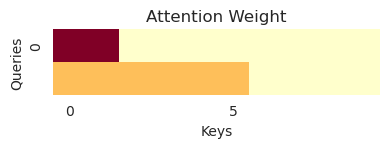

In [15]:
# k的第二个维度（键的数量，记为 KEYS_NUM）和 v的第二个维度（值的数量）必须相同。因为每个键需要对应一个值（key-value对），否则无法一一匹配。

k = torch.ones(2, 10, 2)  # (2, 10, 2)
v = torch.arange(40, dtype=torch.float).reshape(1, 10, 4).repeat(2, 1, 1)  # (2, 10, 4)
q = torch.normal(mean=0, std=1, size=(2, 1, 20))  # (2, 1, 20)

additive_attention = AdditiveAttention(key_dim=2, query_dim=20, hidden_dim=8)
additive_attention.eval()

# (2,1,4)
res = additive_attention(q, k, v, valid_len=torch.tensor([2, 6]))

# (2,1,10)
weights = additive_attention.atten_weights

print(res.shape, weigths.shape)

# 但由于当前批量中的有效长度分别为 2 和 6（valid_len=torch.tensor([2, 6])），且所有键均为 1，使得同一查询得到的原始注意力分数（logits）也相同。
# 于是，生成的注意力权重热图分别在前 2 个位置和前 6 个位置呈现均匀的权重分布
plot_attention_heatmap(weights.reshape((1, 1, 2, 10)), x_label='Keys', y_label='Queries', figsize=(4, 4))

## 5.5 缩放点积注意力实现

In [18]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout: float = 0.1):
        # 调用父类方法
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.attention_weights: Optional[Tensor] = None

    def forward(self, query, key, value, valid_len):
        '''
        Q和 K的特征维度必须相同，K和 V的序列长度必须相同
        :param key: 键，形状为 (BATCH_SIZE, KEYS_NUM, KEYS_DIM)
        :param value: 值，形状为 (BATCH_SIZE, KEYS_NUM, VALUES_DIM)
        :param query: 查询，形状为 (BATCH_SIZE, QUERIES_NUM, QUERIES_DIM)，其中 QUERIES_DIM = KEYS_DIM
        :param valid_len: 有效长度，形状为 (BATCH_SIZE,) 或 (BATCH_SIZE, QUERIES_NUM)
        '''
        _, _, k_dim = key.shape

        # (BATCH_SIZE, QUERIES_NUM, KEYS_NUM)
        logits = torch.bmm(
            query,  # (BATCH_SIZE, QUERIES_NUM, q_k_dim)
            key.transpose(1, 2)  # # (BATCH_SIZE, KEYS_NUM, q_k_dim) -> (BATCH_SIZE, q_k_dim, KEYS_NUM)
        ) / (k_dim ** 0.5)

        self.attention_weights = masked_softmax(logits, valid_len)

        # (BATCH_SIZE, QUERIES_NUM, KEYS_NUM) @ (BATCH_SIZE, KEYS_NUM, VALUES_DIM) = （BATCH_SIZE, QUERIES_NUM,VALUES_DIM）
        return torch.bmm(self.dropout(self.attention_weights), value)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

res.shape  = torch.Size([2, 1, 4])
weights.shape = torch.Size([2, 1, 10])


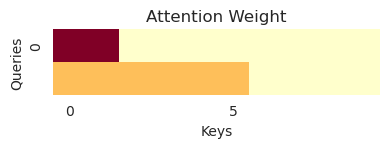

In [19]:
k = torch.ones(2, 10, 2)
#(2,1,2)
q = torch.normal(mean=0, std=1, size=(2, 1, 2))
# (2,10,4)
v = torch.arange(40, dtype=torch.float).reshape(1, 10, 4).repeat(2, 1, 1)

scaled_dot_product_attention = ScaledDotProductAttention()
scaled_dot_product_attention.eval()
res = scaled_dot_product_attention(q, k, v, valid_len=torch.tensor([2, 6]))
weights = scaled_dot_product_attention.attention_weights

print(f'{res}\n\n{res.shape  = }')
print(f'{weights.shape = }')
plot_attention_heatmap(weights.reshape((1, 1, 2, 10)), x_label='Keys', y_label='Queries', figsize=(4, 4))

## 6. 多头注意力

多头注意力（Multi-Head Attention）是 Transformer 模型的核心组件之一，其设计灵感来源于人类“**多视角理解**”的能力。它通过并行计算多个独立的注意力头（Attention Heads），让模型能够从不同的子空间（Subspace）中捕捉上下文信息。

**计算核心**：
将输入的（Q, K, V）分割为多个头，每个头独立计算注意力，最后将各头的输出拼接并融合。

![多头部注意力机制示意图](img/1_multi-head.png)

---

### 6.1 计算步骤

假设输入张量维度为：
$$
Q, K, V \in \mathbb{R}^{B \times L \times d_{\text{model}}}
$$
其中：
- $B$：批量大小（Batch Size）
- $L$：序列长度（Sequence Length）
- $d_{\text{model}}$：模型维度（Model Dimension）

---

#### 1. 分割（Splitting）

将 $Q, K, V$ 的最后一个维度分割为 $h$ 个头，每个头的维度为：
$$
d_k = \frac{d_{\text{model}}}{h}
$$

$Q, K, V$ 可表示为：
$$
Q = [Q_1; Q_2; \dots; Q_h], \quad K = [K_1; K_2; \dots; K_h], \quad V = [V_1; V_2; \dots; V_h]
$$
其中 $Q_i, K_i, V_i \in \mathbb{R}^{B \times L \times d_k}$ 是第 $i$ 个头的查询、键、值。

---

#### 2. 并行计算单头注意力（Parallel Attention Heads）

对每个头 $i$，独立计算 **缩放点积注意力**：
$$
\text{head}_i = \text{ScaledDotProductAttention}(Q_i, K_i, V_i)
$$
其中 $\text{ScaledDotProductAttention}$ 的公式为：
$$
\text{head}_i = \text{softmax}\left( \frac{Q_i K_i^\top}{\sqrt{d_k}} \right) V_i
$$

---

#### 3. 拼接（Concatenate）

将 $h$ 个头的输出 $\text{head}_1, \text{head}_2, \dots, \text{head}_h$ 按最后一个维度拼接，恢复总维度 $d_{\text{model}}$：
$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \dots, \text{head}_h)
$$

---

#### 4. 融合（Linear Projection）

最后，通过一个线性层 $W^O$ 对拼接后的结果进行线性变换，得到最终输出：
$$
\text{Output} = \text{MultiHead}(Q, K, V) W^O
$$
其中：
- $W^O \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}$
- 因 $h \cdot d_k = d_{\text{model}}$，故 $W^O$ 的输入和输出维度一致。

---
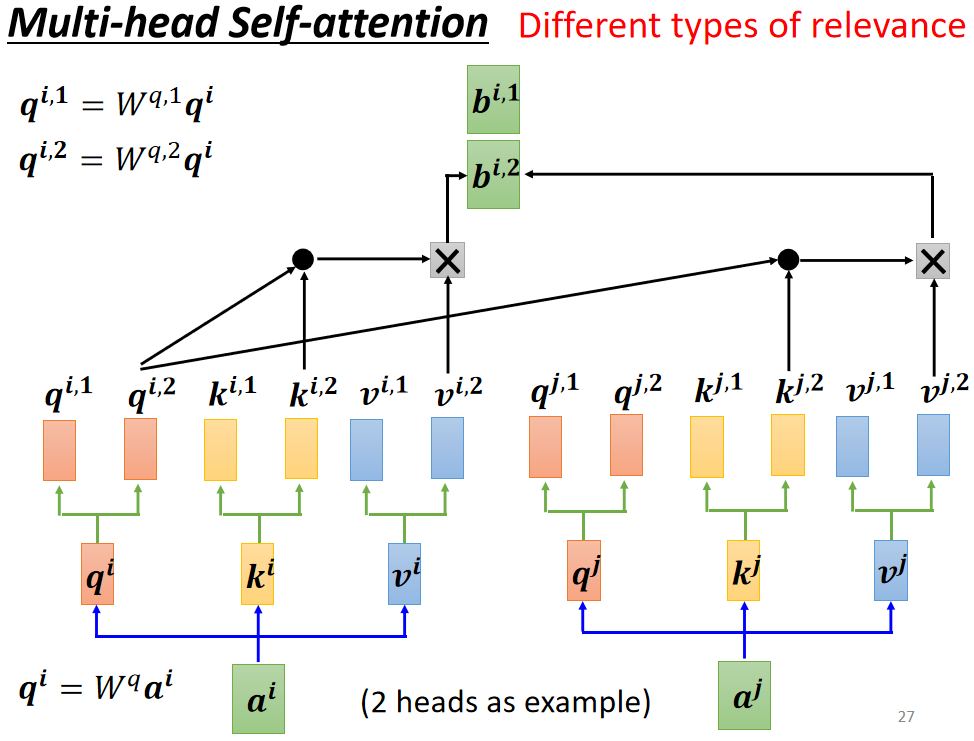
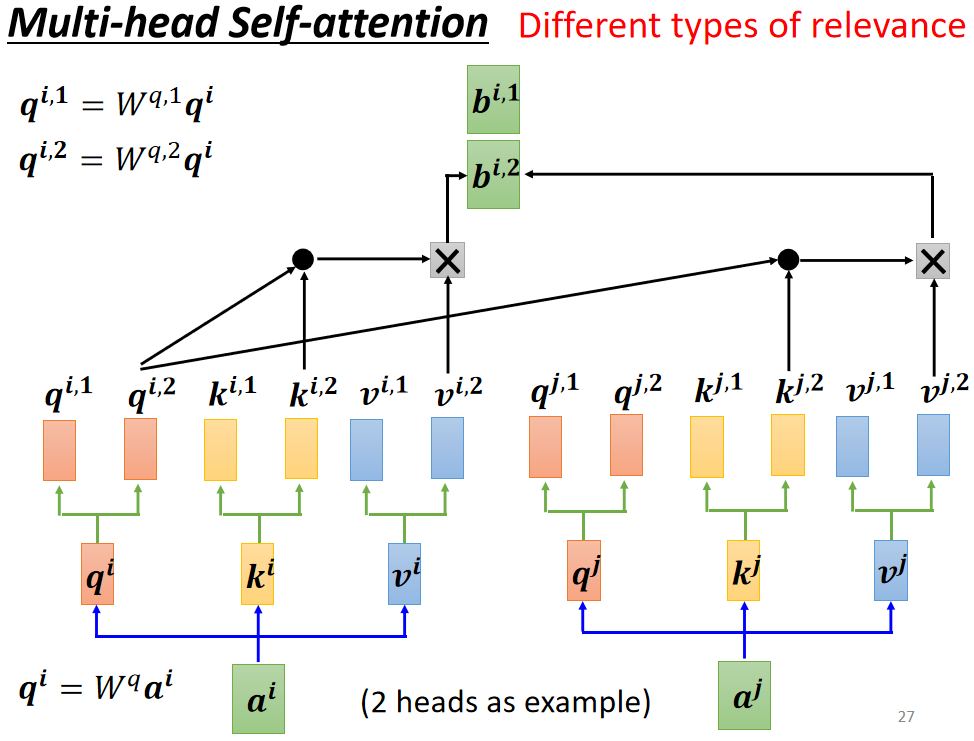
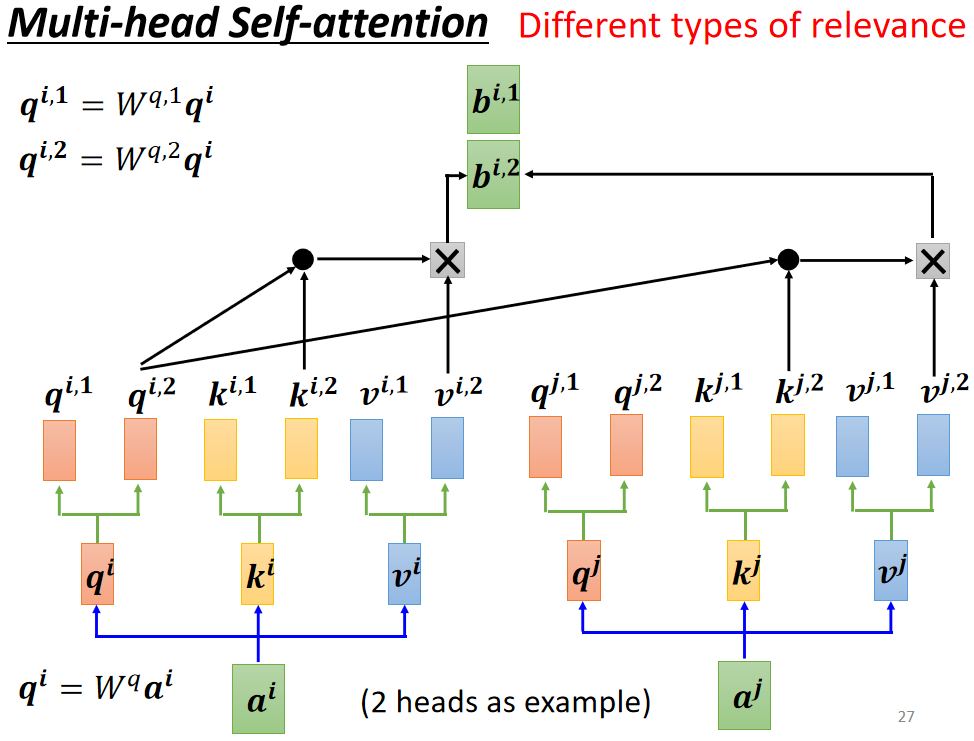
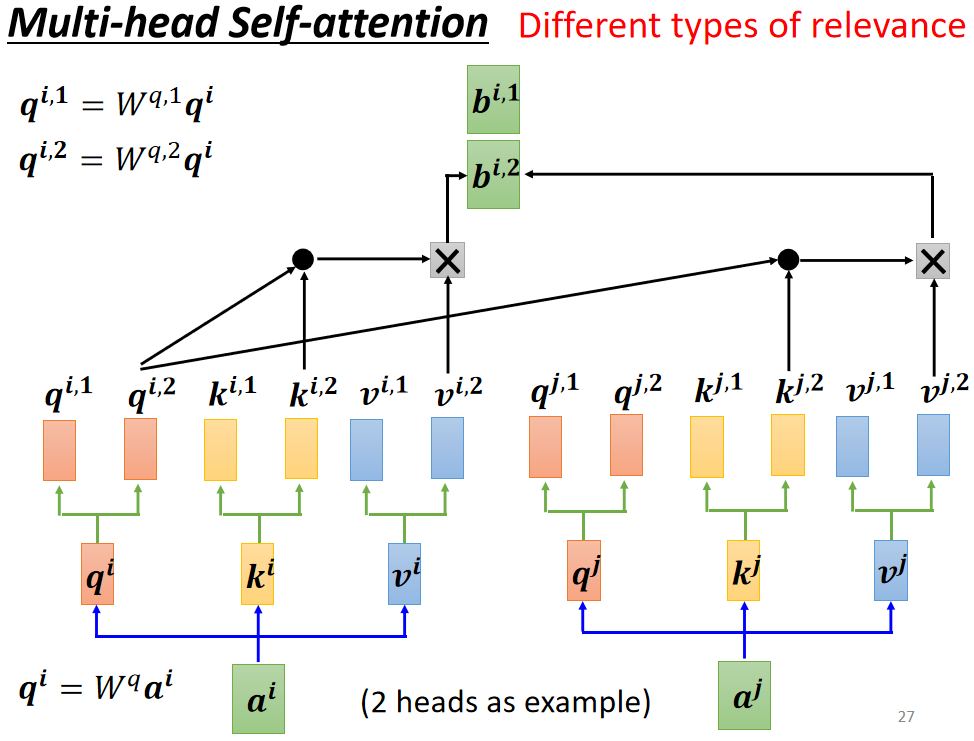

### 6.3 代码实现

In [31]:
from typing import Optional
import torch
from torch import nn, Tensor


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads: int, d_model: int, d_k: int, d_v: int, bias: bool = False, dropout: float = 0.1):
        super().__init__()
        if d_model <= 0 or n_heads <= 0:
            raise ValueError("n_heads or d_model must be positive")
        if d_model % n_heads != 0:
            raise ValueError("n_heads must be divisible by d_model")

        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads  # 每个注意力头的维度
        self.kdim = d_k  # Key 的输入维度
        self.vdim = d_v  # Value 的输入维度

        # 线性投影层
        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(self.kdim, d_model, bias=bias)
        self.v_proj = nn.Linear(self.vdim, d_model, bias=bias)
        self.o_proj = nn.Linear(d_model, d_model, bias=bias)

        # 注意力计算模块
        self.atten_score = ScaledDotProductAttention(dropout=dropout)
        self.atten_weights: Optional[Tensor] = None  # 存储注意力权重

    def forward(self, query: Tensor, key: Tensor, value: Tensor, valid_len: Tensor) -> Tensor:
        self.atten_weights = None  # 重置注意力权重

        # 投影 Query, Key, Value
        q_proj = self.q_proj(query)  # (BATCH_SIZE, Q_NUM, d_model)
        k_proj = self.k_proj(key)  # (BATCH_SIZE, K_NUM, d_model)
        v_proj = self.v_proj(value)  # (BATCH_SIZE, V_NUM, d_model)

        # 转置为多头格式
        q_heads = self._transpose_qkv(q_proj)  # (BATCH_SIZE * n_heads, Q_NUM, head_dim)
        k_heads = self._transpose_qkv(k_proj)  # (BATCH_SIZE * n_heads, K_NUM, head_dim)
        v_heads = self._transpose_qkv(v_proj)  # (BATCH_SIZE * n_heads, V_NUM, head_dim)

        # 扩展 valid_len 到每个注意力头
        valid_len = torch.repeat_interleave(valid_len, repeats=self.n_heads, dim=0)  # (BATCH_SIZE * n_heads,)

        # 计算注意力输出
        attn_output = self.atten_score(q_heads, k_heads, v_heads, valid_len)  # (BATCH_SIZE * n_heads, Q_NUM, head_dim)

        # 合并多头输出
        output_concat = self._transpose_o(attn_output)  # (BATCH_SIZE, Q_NUM, d_model)

        self.atten_weights = (self.atten_score.attention_weights  # (BATCH_SIZE * num_heads, QUERIES_NUM, KEYS_NUM)
                              .reshape(query.shape[0], self.n_heads, query.shape[1], key.shape[1]))
        return self.o_proj(output_concat)  # (BATCH_SIZE, Q_NUM, d_model)

    def _transpose_qkv(self, x: Tensor) -> Tensor:
        """
        将输入张量从 (BATCH_SIZE, SEQ_LEN, d_model) 转换为多头格式：
        (BATCH_SIZE * n_heads, SEQ_LEN, head_dim)

        Args:
            x: 输入张量，形状为 (BATCH_SIZE, SEQ_LEN, d_model)

        Returns:
            多头格式张量，形状为 (BATCH_SIZE * n_heads, SEQ_LEN, head_dim)
        """
        batch_size, seq_len, _ = x.shape
        x = x.reshape(batch_size, seq_len, self.n_heads, self.head_dim)  # (B, L, H, D)
        x = x.permute(0, 2, 1, 3)  # (B, H, L, D)
        x = x.reshape(-1, seq_len, self.head_dim)  # (B*H, L, D)
        return x

    def _transpose_o(self, x: Tensor) -> Tensor:
        """
        将多头输出从 (BATCH_SIZE * n_heads, SEQ_LEN, head_dim) 恢复为原始格式：
        (BATCH_SIZE, SEQ_LEN, d_model)

        Args:
            x: 多头输出张量，形状为 (BATCH_SIZE * n_heads, SEQ_LEN, head_dim)

        Returns:
            原始格式张量，形状为 (BATCH_SIZE, SEQ_LEN, d_model)
        """
        batch_times_heads, seq_len, _ = x.shape
        batch_size = batch_times_heads // self.n_heads
        x = x.reshape(batch_size, self.n_heads, seq_len, self.head_dim)  # (B, H, L, D)
        x = x.permute(0, 2, 1, 3)  # (B, L, H, D)
        x = x.reshape(batch_size, seq_len, self.d_model)  # (B, L, D)
        return x

输入形状: [2, 10, 512]
输出形状: [2, 10, 512]
注意力权重形状: torch.Size([2, 8, 10, 10])


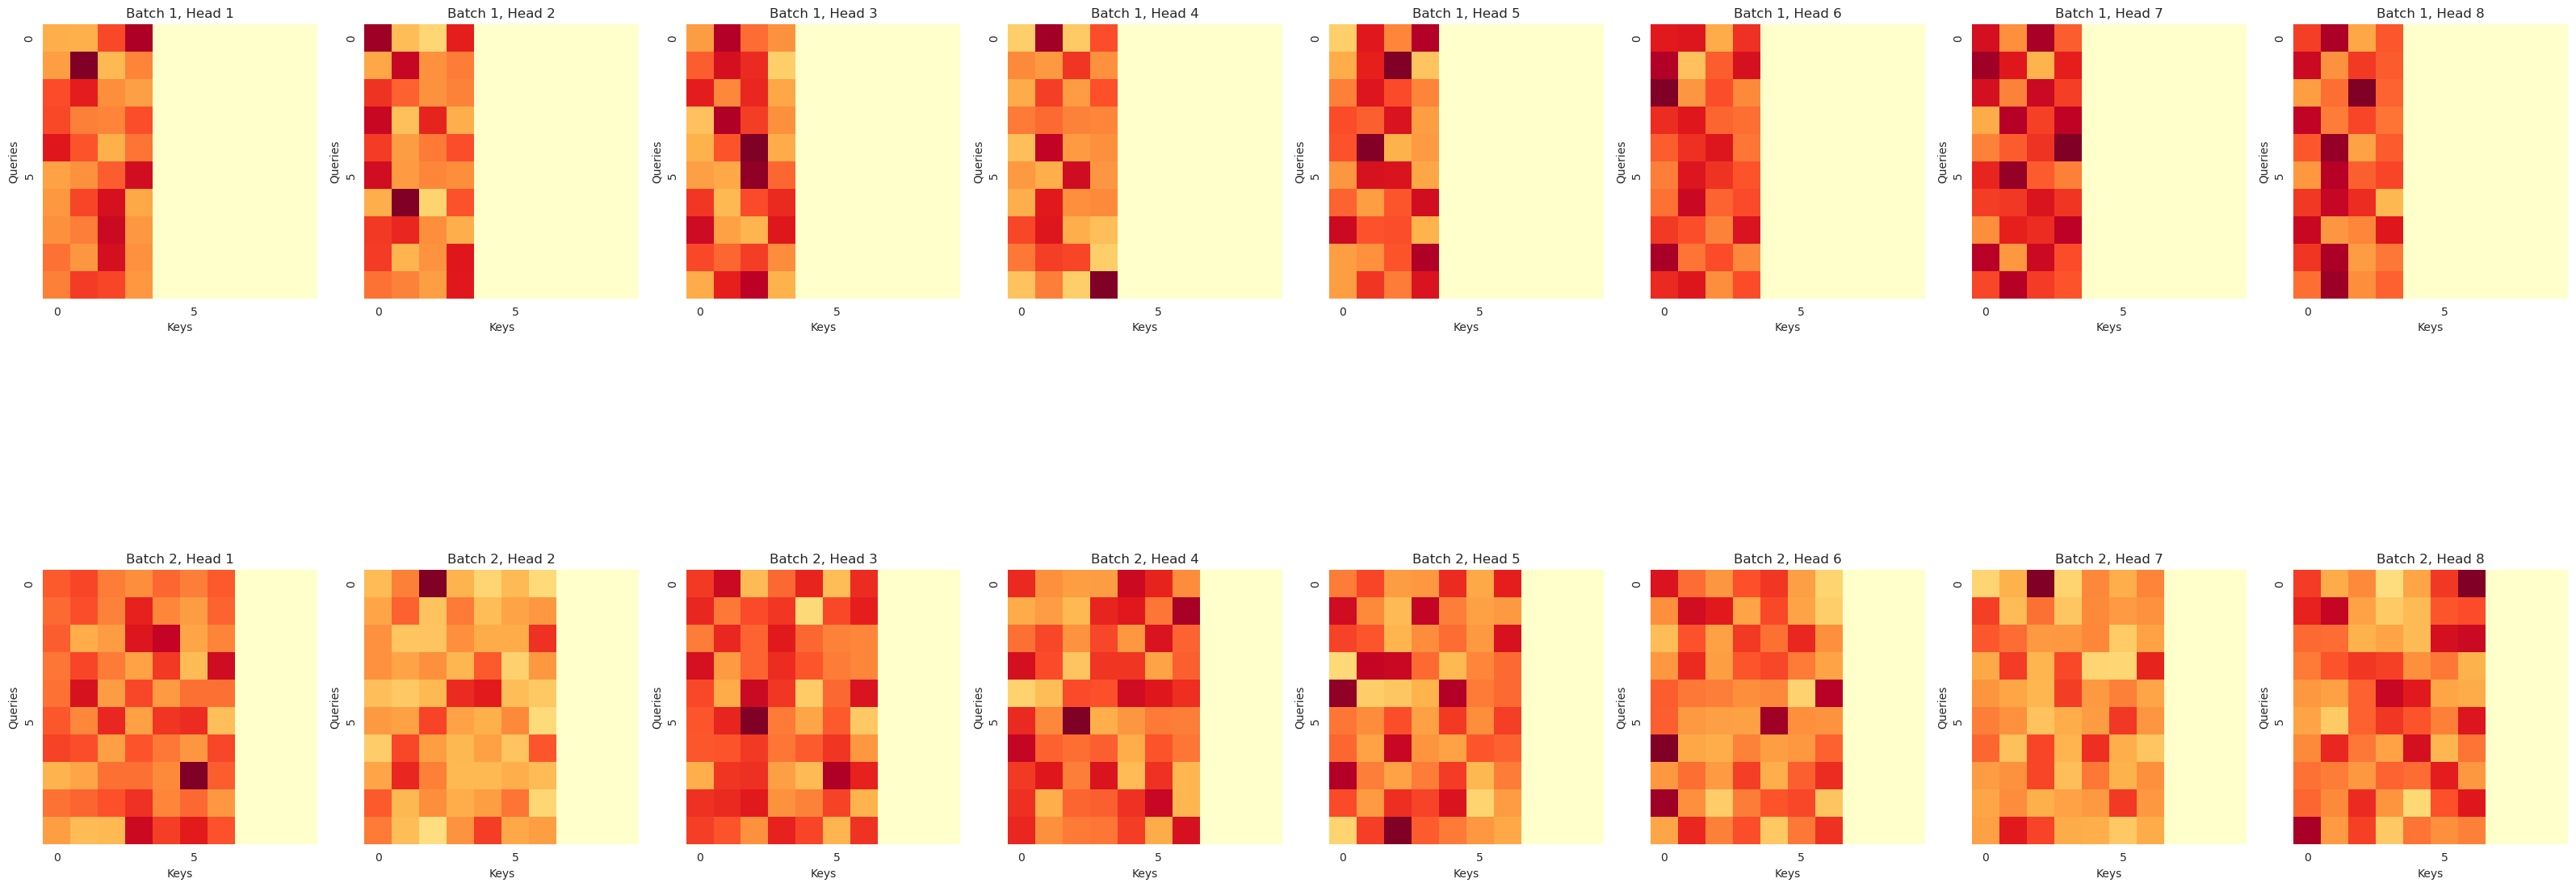

In [39]:
d_model = 512
n_heads = 8
batch_size = 2
sql_len = 10

q = torch.randn(batch_size, sql_len, d_model)
k = torch.randn(batch_size, sql_len, d_model)
v = torch.randn(batch_size, sql_len, d_model)
valid_len = torch.tensor([4, 7])

multi_head_attention = MultiHeadAttention(n_heads, d_model, d_model, d_model)
multi_head_attention.eval()
o = multi_head_attention(q, k, v, valid_len)

print(f'输入形状: {list(q.shape)}')
print(f'输出形状: {list(o.shape)}')
print(f'注意力权重形状: {multi_head_attention.atten_weights.shape}')
plot_attention_heatmap(multi_head_attention.atten_weights, x_label='Keys', y_label='Queries',
                       title=[f'Batch {i + 1}, Head {j + 1}' for i in range(batch_size) for j in range(n_heads)],
                       figsize=(16, 2))


# 7. 自注意力机制（Self-Attention）

自注意力的核心目标是：为序列中的每个元素（如文本中的词、图像中的像素块）动态分配与其他元素的关联权重，从而捕捉序列内部的全局依赖关系。

![自注意力](img/2_self_attention.png)

## 7.1 数学推导

### 1. 输入表示
设输入序列为 $ X = [x_1, x_2, \dots, x_n] $，其中 $ n $ 表示序列长度，每个元素 $ x_i \in \mathbb{R}^{d_{\text{model}}} $。

---

### 2. 线性变换
通过三个可学习的权重矩阵 $ W^Q \in \mathbb{R}^{d_{\text{model}} \times d_k} $、$ W^K \in \mathbb{R}^{d_{\text{model}} \times d_k} $、$ W^V \in \mathbb{R}^{d_{\text{model}} \times d_v} $，将输入 $ X $ 投影为查询（Query）、键（Key）和值（Value）矩阵：
$$
Q = XW^Q,\quad K = XW^K,\quad V = XW^V
$$
其中：
- $ d_k $：查询/键的维度；
- $ d_v $：值的维度；
- 通常设置 $ d_k = d_v $ 以简化计算。

---

### 3. 注意力分数计算：点积与缩放
计算查询 $ q_i \in Q $ 与所有键 $ k_j \in K $ 的相关性，通过点积定义注意力分数 $ \text{Scores}_{i,j} $：
$$
\text{Scores}_{i,j} = q_i \cdot k_j^\top
$$
为缓解高维点积导致的数值不稳定问题（如梯度消失），引入缩放因子 $ \sqrt{d_k} $：
$$
\text{Scores}_{i,j} = \frac{q_i \cdot k_j^\top}{\sqrt{d_k}}
$$

---

### 4. Softmax归一化：生成注意力权重
对每行（对应每个查询 $ q_i $）的注意力分数进行 Softmax 归一化，得到注意力权重矩阵 $ A \in \mathbb{R}^{n \times n} $，其中 $ A_{i,j} $ 表示位置 $ i $ 对位置 $ j $ 的关注程度：
$$
A = \text{softmax}\left( \frac{Q K^\top}{\sqrt{d_k}} \right)
$$
Softmax 的性质保证：
- 每行权重和为 1：$ \sum_{j=1}^n A_{i,j} = 1 $；
- 权重越大，表明 $ x_i $ 与 $ x_j $ 的依赖关系越强。

---

### 5. 加权求和：生成上下文感知输出
利用注意力权重 $ A $ 对值矩阵 $ V $ 进行加权求和，得到输出 $ Z \in \mathbb{R}^{n \times d_v} $：
$$
Z = A V
$$
输出 $ Z $ 的每个元素 $ z_i $ 是 $ V $ 中所有 $ v_j $ 的加权组合，权重由 $ x_i $ 与 $ x_j $ 的相关性决定。该过程实现了对序列全局依赖关系的建模。

### 7.3 自注意力代码实现



In [47]:
from typing import Optional
import torch
from torch import nn, Tensor


class SelfAttention(nn.Module):

    def __init__(self, d_model: int, d_k: int, d_v: int, bias: bool = False, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.q_proj = nn.Linear(d_model, d_k, bias=bias)
        self.k_proj = nn.Linear(d_model, d_k, bias=bias)
        self.v_proj = nn.Linear(d_model, d_v, bias=bias)

        self.atten_score = ScaledDotProductAttention(dropout=dropout)
        self.out_proj = nn.Linear(d_v, d_model, bias=bias)  # 添加输出投影层

        self.atten_weights: Optional[Tensor] = None

    def forward(self, query: Tensor, key: Tensor, value: Tensor, valid_len: Tensor) -> Tensor:
        self.atten_weights = None

        # 投影 Query, Key, Value
        q_proj = self.q_proj(query)  # (BATCH_SIZE, Q_NUM, d_k)
        k_proj = self.k_proj(key)  # (BATCH_SIZE, K_NUM, d_k)
        v_proj = self.v_proj(value)  # (BATCH_SIZE, V_NUM, d_v)

        # 计算注意力输出
        attn_output = self.atten_score(q_proj, k_proj, v_proj, valid_len)  # (BATCH_SIZE, Q_NUM, d_v)
        ouput = self.out_proj(attn_output)

        # 存储注意力权重（假设 atten_score 返回 (BATCH_SIZE, Q_NUM, K_NUM)）
        self.atten_weights = self.atten_score.attention_weights.unsqueeze(1)  # (BATCH_SIZE, Q_NUM, K_NUM)

        # 输出投影到 d_model
        return ouput  # (BATCH_SIZE, Q_NUM, d_model)


torch.Size([2, 10, 512]) torch.Size([2, 1, 10, 10])


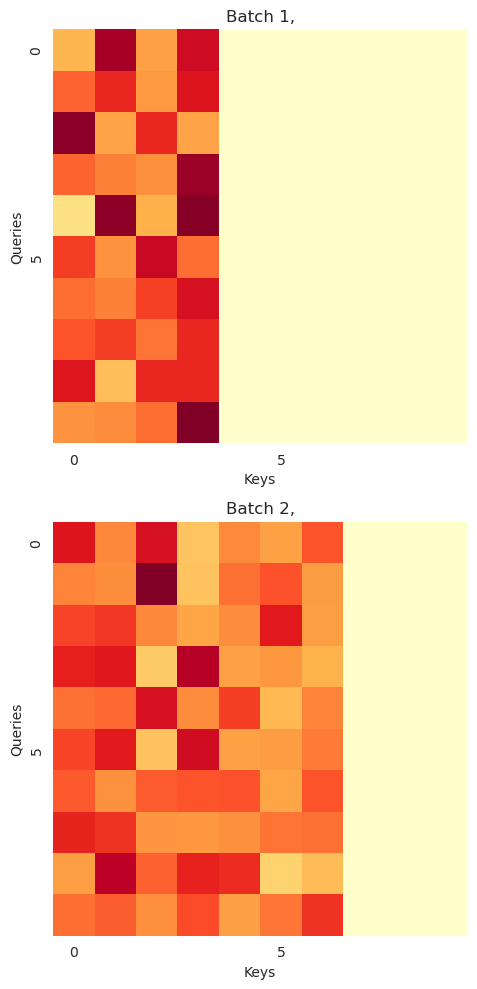

In [52]:
d_model = 512
d_k = 8
batch_size = 2
sql_len = 10

q = torch.randn(batch_size, sql_len, d_model)
k = torch.randn(batch_size, sql_len, d_model)
v = torch.randn(batch_size, sql_len, d_model)
valid_len = torch.tensor([4, 7])

self_attention = SelfAttention(d_model, d_k, d_model)
self_attention.eval()

out=self_attention(q, k, v, valid_len)
print(out.shape,self_attention.atten_weights.shape)
plot_attention_heatmap(self_attention.atten_weights, x_label='Keys', y_label='Queries',
                       title=[f'Batch {i + 1},' for i in range(batch_size) ],
                       figsize=(5, 10))